# Summarising and Plotting Statistics

After a successful run of `run_topostats` you will have a `all_statistics.csv` file that contains a summary of various
statistics about the detected molecules across all image files that were processed. There is class
`topostats.plotting.TopoSum` that uses this file to generate plots automatically and a convenience command
`toposum` which provides an entry point to re-run the plotting at the command line.

Inevitably though there will be a point where you want to tweak plots for publication or otherwise in some manner that
is not conducive to scripting in this manner because making every single option from
[Seaborn](https://seaborn.pydata.org/) and [Matplotlib](https://matplotlib.org/) accessible via this class is a
considerable amount of work writing [boilerplate code](https://en.wikipedia.org/wiki/Boilerplate_code). Instead the
plots should be generated and tweaked interactively a notebook. This Notebook serves as a sample showing how to use the
`TopoSum` class and some examples of creating plots directly using [Pandas](https://pandas.pydata.org/).

If you are unfamiliar with these packages it is recommended that you read the documentation. It is worth bearing in mind
that both Pandas and Seaborn build on the basic functionality that Matplotlib provides, providing easier methods for
generating plots. If you are stuck doing something with either of these refer to Matplotlib for how to achieve what you
are trying to do.

* [Pandas](https://pandas.pydata.org/docs/)
* [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
* [Chart visualization — pandas](https://pandas.pydata.org/docs/user_guide/visualization.html?highlight=plotting)
* [seaborn: statistical data visualization](https://seaborn.pydata.org/index.html)
* [An introduction to seaborn](https://seaborn.pydata.org/tutorial/introduction.html)
* [Matplotlib — Visualization with Python](https://matplotlib.org/)
* [Tutorials — Matplotlib](https://matplotlib.org/stable/tutorials/index)



## Load Libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from topostats.plotting import TopoSum

## Load  `all_statistics.csv`

You need to load your data to be able to work with it, this is best achieved by importing it using
[Pandas](https://pandas.pydata.org/). Here we use the `tests/resources/minicircle_default_all_statistics.csv` that is
part of the TopoStats repository and load it into the object called `df` (short for "Data Frame"). You will need to
change this path to reflect your output. 

Because `molecule_number` is unique to the `image` and `threshold` we set a multi-level index of these three

In [2]:
df = pd.read_csv("../tests/resources/minicircle_default_all_statistics.csv")
df.set_index(["image", "threshold", "molecule_number"], inplace=True)


## Plotting with Pandas

### Plotting Contour Lengths

<AxesSubplot: title={'center': 'Contour Lengths'}, ylabel='Frequency'>

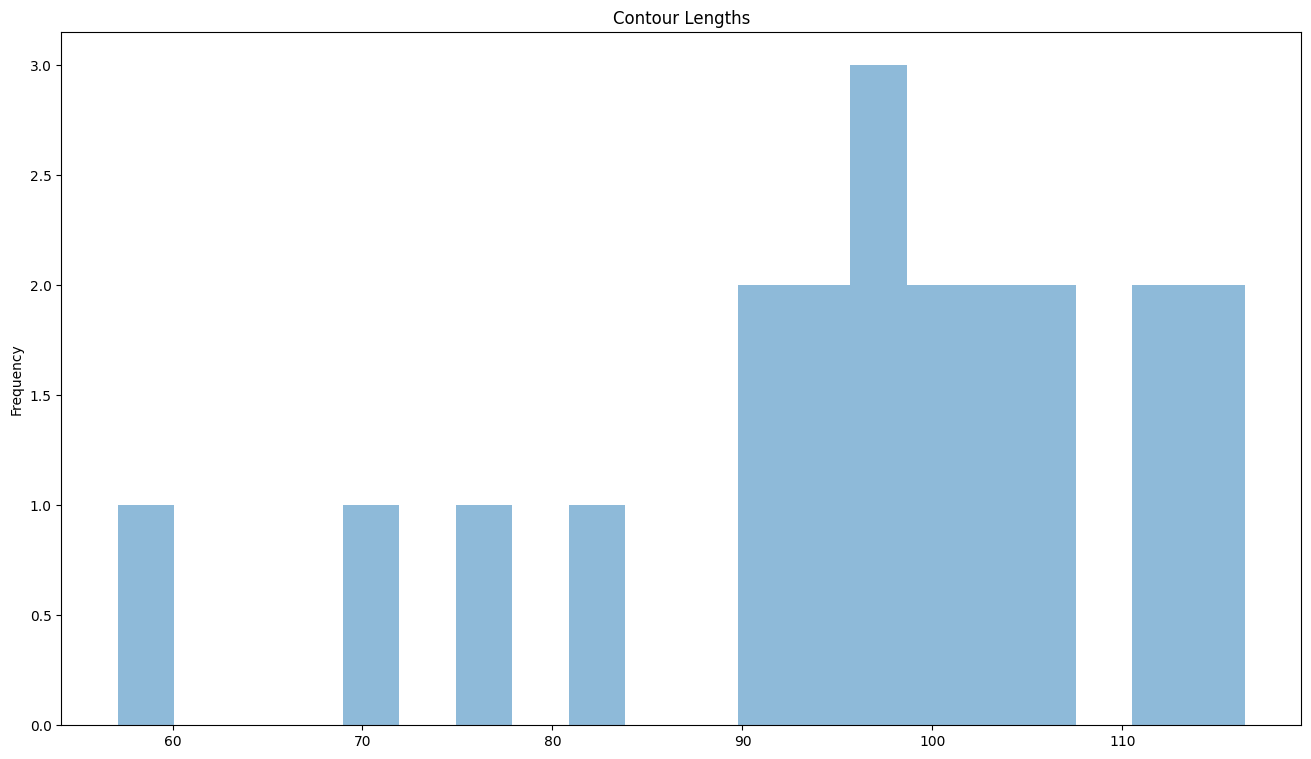

In [3]:
df["contour_lengths"].plot.hist(figsize=(16,9),
                                bins=20,
                                title="Contour Lengths",
                                alpha=0.5)

### Plotting End to End Distance of non-Circular grains

Circular grains are excluded since their end-to-end length is 0.0.

<AxesSubplot: title={'center': 'End to End Distance'}, ylabel='Frequency'>

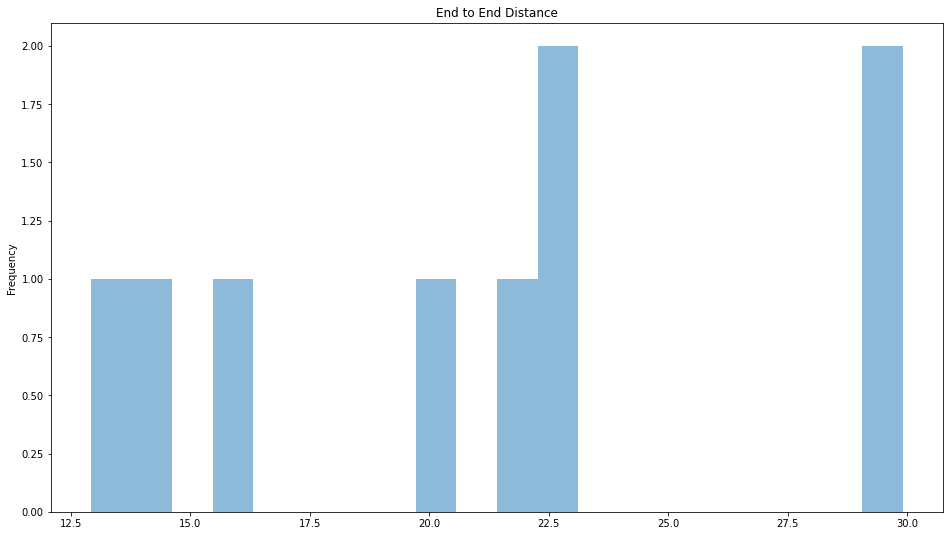

In [3]:
df[df["circular"] == False]["end_to_end_distance"].plot.hist(figsize=(16,9),
                                                             bins=20,
                                                             title="End to End Distance",
                                                             alpha=0.5)

### Multiple Images

Often you will have processed multiple images and you will want to plot the distributions of metrics for each image
separately.

For this example we duplicate the data and append it, adjusting the values slightly

In [11]:
def scale_df(df: pd.DataFrame, scale:float, image:str) -> pd.DataFrame:
    """Scale the numerical values of a data frame. Retains string variables and the index.

    Parameters
    ----------
    df: pd.DataFrame
        Pandas Dataframe to scale.
    scale: float
        Factor by which to scale the data.
    image: str
        Name for new (dummy) image.

    Returns
    -------
    pd.DataFrame
        Scaled data frame
    """
    _df = df[df.select_dtypes(include=['number']).columns] * scale
    _df.reset_index(inplace=True)
    _df["image"] = image
    _df = pd.concat([_df, df[["circular", "basename"]]], axis=1)
    _df.set_index(["image", "threshold", "molecule_number"], inplace=True)
    return _df
smaller = scale_df(df, scale=0.9, image="smaller")
larger = scale_df(df, scale=1.25, image="larger")
df_three_images = pd.concat([smaller, df, larger])

### Contour Length from Three Processed Images

image
larger            AxesSubplot(0.125,0.125;0.775x0.755)
minicircle.spm    AxesSubplot(0.125,0.125;0.775x0.755)
smaller           AxesSubplot(0.125,0.125;0.775x0.755)
Name: contour_lengths, dtype: object

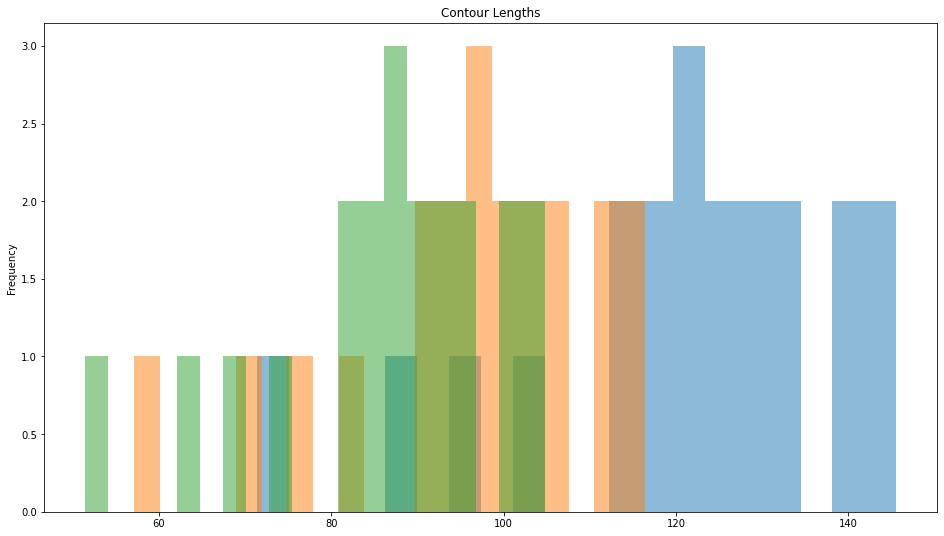

In [12]:
df_three_images["contour_lengths"].groupby("image").plot.hist(
    figsize=(16,9),
    bins=20,
    # bins=np.linspace(start, stop, num=x), # Use this if there are different number of grains per image
    title="Contour Lengths",
    alpha=0.5
)

### Ignoring Image

It is possible to plot the distribution of summary statistics without regard to the image from which they are
derived. Simply omit the `.groupby("image")` from the plotting command.

We also manually set the `fontsize`.

<AxesSubplot: title={'center': 'Contour Lengths'}, ylabel='Frequency'>

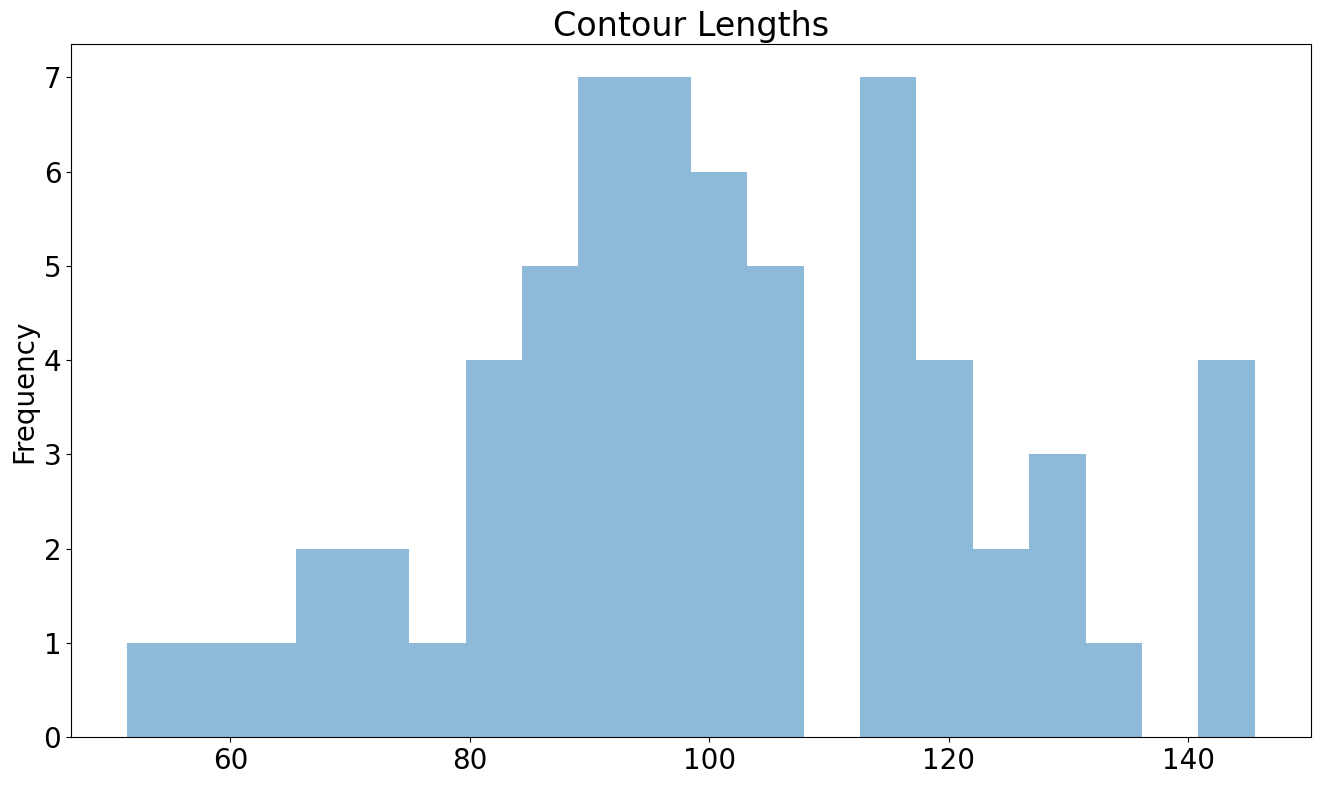

In [7]:
matplotlib.rcParams.update({"font.size": 20})
df_three_images["contour_lengths"].plot.hist(figsize=(16,9),
                                bins=20,
                                title="Contour Lengths",
                                alpha=0.5)

### Violin Plot of `max_feret` using Seaborn

Pandas does not have built-in support for Violin Plots so we switch to using Seaborn. Here the `fig` and `ax` objects
are created first and we use the `ax.text()` method to add a string (`text_str`) in a box to the plot.

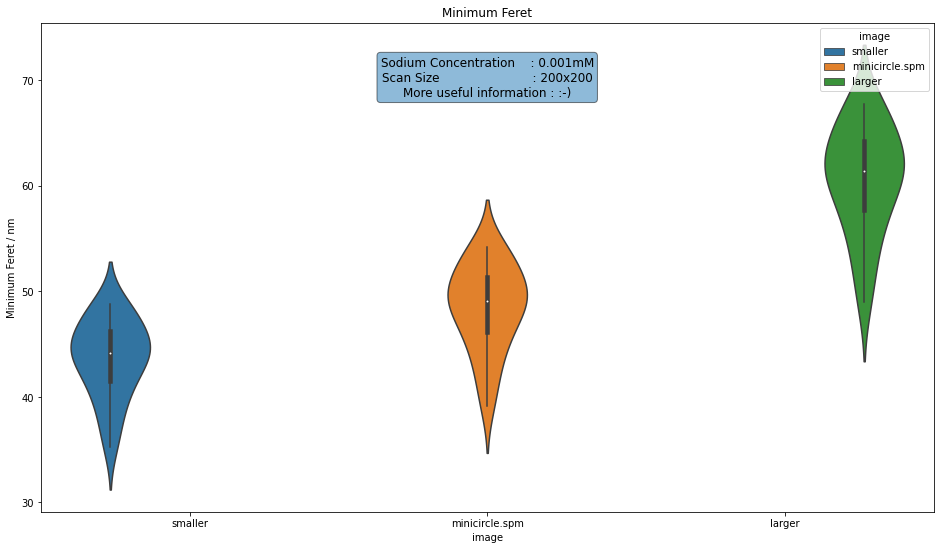

In [13]:
# Reset dataframe index to make `image` readily available
df_three_images.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16,9))
sns.violinplot(data=df_three_images, x="image", y="max_feret", hue="image", alpha=0.5)
plt.title("Minimum Feret")
plt.ylabel("Minimum Feret / nm")
# Define text for the string to go in a blue text box.
text_str = "\n".join(["Sodium Concentration    : 0.001mM",
                      "Scan Size                        : 200x200",
                      "More useful information : :-)"])
props = dict(boxstyle="round", alpha=0.5)
ax.text(0.5, 0.85, text_str, transform=ax.transAxes, fontsize=12, #verticalalignment="top",
        horizontalalignment="center", bbox=props)
# Return the index
df_three_images.set_index(["image", "threshold", "molecule_number"], inplace=True)

### Joint Plot
[Joint  Plots](https://seaborn.pydata.org/generated/seaborn.jointplot.html) showing the relationship between two variables can be plotted easily.

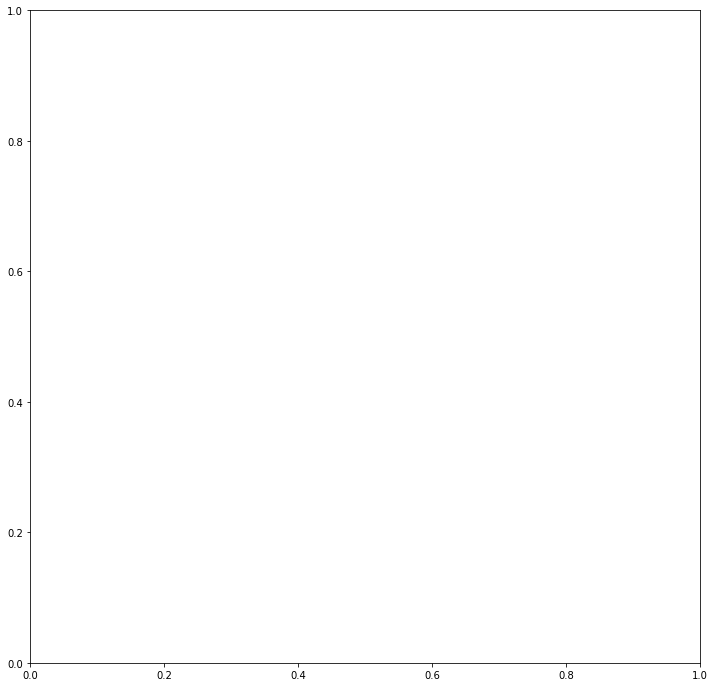

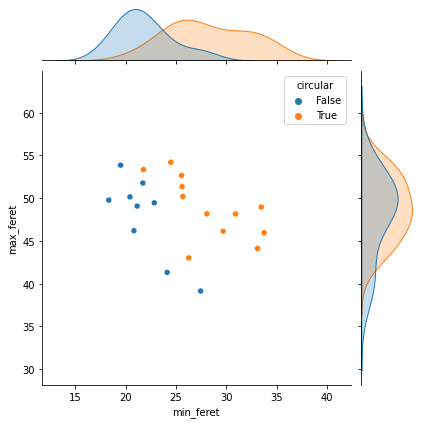

In [9]:
df.columns
sns.jointplot(data=df, x="min_feret", y="max_feret", hue="circular")

# Loading Pickles

One of the features of the `topostats.plotting` module is that it will save the graphs it has generated in Python's own
format for storing objects. These are known as [pickles](https://realpython.com/python-pickle-module/) and typically
have the file extension `.pkl`. After running TopoStats and plotting distributions of statistics a `.pkl` will by
default be saved in the output directory. Here we load  ("unpickle") such a saved file which is typically located at
~output/summary_distributions/distribution_plots.pkl~ and check its type (its a ~dict~ionary of plots).

TopoStats includes the ~load_pkl~ function which loads and returns the contents of the file.

In [ ]:
from pathlib import Path

from topostats.io import load_pkl

# NB - If you get an error saying the file could not be found then you need to modify this line to point to the location
# the file was saved to.
pkl_path = Path("../output/summary_distributions/distribution_plots.pkl")
my_plots = load_pkl(pkl_path)
# Show the type of my_plots which is a dictionary of nested dictionaries
type(my_plots)


The object ~my_plots~ is a nested dictionary the "keys" to the dictionary are the names of the statistic that have been
plotted, and the values of these are themselves dictionaries of the types of plots that have been generated. We can
check what statistics were plotted and saved in a pickle by looking at the first level of keys.

In [ ]:
my_plots.keys()

We see that the `area`, `xxx` and `yyy` statistics were plotted. We can now look at what types of plots were generated
by checking the keys for the dictionary nested under this top-level (**NB** because of the way plots are generated all
statistics will have the same plots generated).

In [ ]:
my_plots["area"].keys()

We see that both `dist` and `violin` plots were generated. To extract these to objects we unpack the values of the
dictionary. The following extracts the `figure` (the plot itself) and its `ax` (the "axes" which are the properties of
the plot) to their own objects.

In [ ]:
figure_area_dist, ax_area_dist = my_plots["area"]["dist"].values()
figure_area_violin, ax_area_violin = my_plots["area"]["violin"].values()
figure_contour_lengths_violin, ax_contour_lengths_violin = my_plots["contour_lengths"]["violin"].values()


We can now look at the figure and modify these as we would like, for example to change the `title` and `xlabel` values.

In [ ]:
ax_area_dist.set_title("This is the Area of minicircle grains")
ax_area_dist.set_xlabel("Area in nanometres squared")
figure_area_dist

In [ ]:
ax_area_dist.keys()
